In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.linear_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,8)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

y = train_data["Survived"]
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X_train = pd.get_dummies(train_data[features])
# X_train = train_data.drop(["Survived"], axis = 1)
x_test = pd.get_dummies(test_data[features])

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## 1. Missing values and data scaling
### 1.1 Check missing values

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         714 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


In [6]:
X_train.isnull().sum()

Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [7]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         332 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        417 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 18.5 KB


In [8]:
x_test.isnull().sum()

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

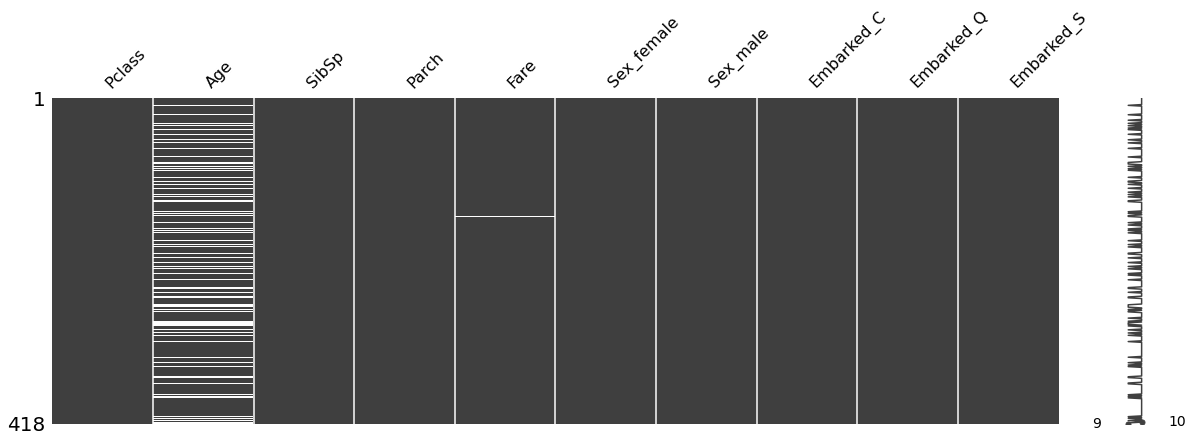

In [9]:
mno.matrix(x_test, figsize = (20, 6))  # Realizing the missingness

### 1.2 Data scaling (age and fear) and replace missing values with 0

In [10]:
scaler = MinMaxScaler(feature_range = (1, 2))
X_train["Fare"] = scaler.fit_transform(pd.DataFrame(X_train["Fare"]))
X_train["Age"] = scaler.fit_transform(pd.DataFrame(X_train["Age"]))
x_test["Fare"] = scaler.fit_transform(pd.DataFrame(x_test["Fare"]))
x_test["Age"] = scaler.fit_transform(pd.DataFrame(x_test["Age"]))
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1.271174,1,0,1.014151,0,1,0,0,1
1,1,1.472229,1,0,1.139136,1,0,1,0,0
2,3,1.321438,0,0,1.015469,1,0,0,0,1
3,1,1.434531,1,0,1.103644,1,0,0,0,1
4,3,1.434531,0,0,1.015713,0,1,0,0,1


In [11]:
X_train.fillna(0, inplace = True)
x_test.fillna(0, inplace = True)

## 2. NN with Keras

In [12]:
x_train, x_dev, y_train, y_dev = train_test_split(X_train, y, test_size = 0.15, random_state = 221)
x_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
237,2,1.095250,0,2,1.051237,1,0,0,0,1
653,3,0.000000,0,0,1.015282,1,0,0,1,0
584,3,0.000000,0,0,1.017006,0,1,1,0,0
756,3,1.346569,0,0,1.015216,0,1,0,0,1
616,3,1.421965,1,1,1.028107,0,1,0,0,1


In [13]:
x_train.shape

(757, 10)

### 2.1 LINEAR-> Relu (4) -> LINEAR-> Relu (8) -> LINEAR -> SIGMOID model

In [14]:
nn_model = Sequential()

nn_model.add(Dense(4, input_shape = (x_train.shape[1],), activation = 'relu'))
nn_model.add(Dense(8, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

nn_model.compile(loss = ['binary_crossentropy'], metrics=['binary_accuracy'], optimizer = 'adam')

# nn_model.compile(optimizer =optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = nn_model.fit(x_train, y_train, epochs = 350, batch_size = 128, validation_data = (x_dev, y_dev))

Epoch 1/350
6/6 [==============================] - 0s 47ms/step - loss: 0.6788 - binary_accuracy: 0.6328 - val_loss: 0.7197 - val_binary_accuracy: 0.5224
Epoch 2/350
6/6 [==============================] - 0s 9ms/step - loss: 0.6763 - binary_accuracy: 0.6328 - val_loss: 0.7186 - val_binary_accuracy: 0.5224
Epoch 3/350
6/6 [==============================] - 0s 9ms/step - loss: 0.6740 - binary_accuracy: 0.6328 - val_loss: 0.7182 - val_binary_accuracy: 0.5224
Epoch 4/350
6/6 [==============================] - 0s 9ms/step - loss: 0.6715 - binary_accuracy: 0.6328 - val_loss: 0.7174 - val_binary_accuracy: 0.5224
Epoch 5/350
6/6 [==============================] - 0s 10ms/step - loss: 0.6694 - binary_accuracy: 0.6328 - val_loss: 0.7174 - val_binary_accuracy: 0.5224
Epoch 6/350
6/6 [==============================] - 0s 9ms/step - loss: 0.6671 - binary_accuracy: 0.6328 - val_loss: 0.7171 - val_binary_accuracy: 0.5224
Epoch 7/350
6/6 [==============================] - 0s 9ms/step - loss: 0.6651 - 

In [15]:
def show_acc(history):
    plt.clf()
    history_dict = history.history
    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']

    epochs = range(1, len(val_acc) + 1)

    plt.plot(epochs, acc, 'r', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accurate')
    plt.legend()
    plt.show()

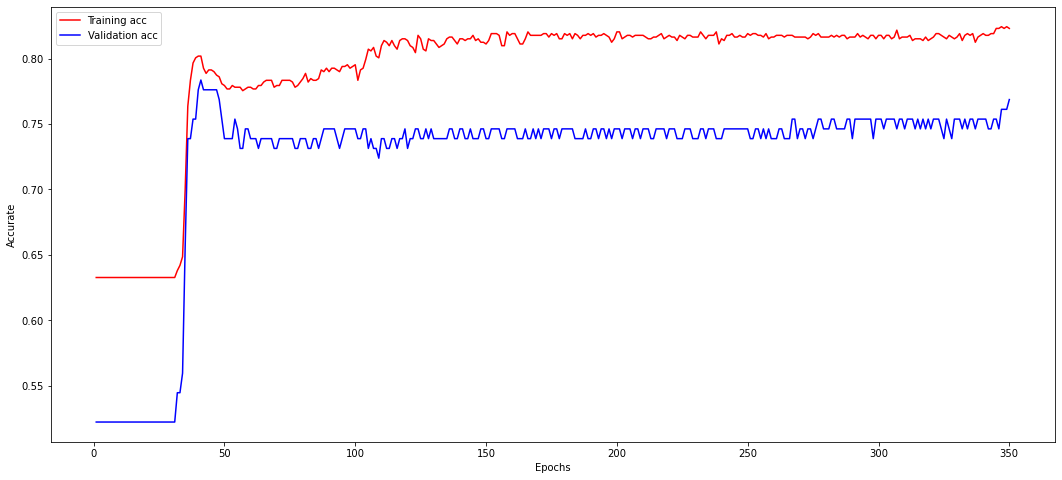

In [16]:
show_acc(history)

In [17]:
pred0 = nn_model.predict_classes(x_test)
pred0.reshape((418,))

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [18]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred0.reshape((418,))})
output.to_csv('nn0.csv', index = False)

### 2.2 LINEAR-> Relu (8) -> LINEAR-> Relu (16) -> LINEAR -> SIGMOID model

In [19]:
nn_model1 = Sequential()

nn_model1.add(Dense(8, input_shape = (x_train.shape[1],), activation = 'relu'))
nn_model1.add(Dense(16, activation = 'relu'))
nn_model1.add(Dense(1, activation = 'sigmoid'))

nn_model1.compile(loss = ['binary_crossentropy'], metrics=['binary_accuracy'], optimizer = 'adam')

# nn_model.compile(optimizer =optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history1 = nn_model1.fit(x_train, y_train, epochs = 500, batch_size = 128, validation_data = (x_dev, y_dev))

Epoch 1/500
6/6 [==============================] - 0s 25ms/step - loss: 0.6795 - binary_accuracy: 0.5667 - val_loss: 0.6858 - val_binary_accuracy: 0.4925
Epoch 2/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6621 - binary_accuracy: 0.5733 - val_loss: 0.6815 - val_binary_accuracy: 0.5149
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6467 - binary_accuracy: 0.6367 - val_loss: 0.6790 - val_binary_accuracy: 0.5448
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6359 - binary_accuracy: 0.6354 - val_loss: 0.6776 - val_binary_accuracy: 0.5597
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6262 - binary_accuracy: 0.6314 - val_loss: 0.6748 - val_binary_accuracy: 0.5597
Epoch 6/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6182 - binary_accuracy: 0.6394 - val_loss: 0.6708 - val_binary_accuracy: 0.5821
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 0.6095 - 

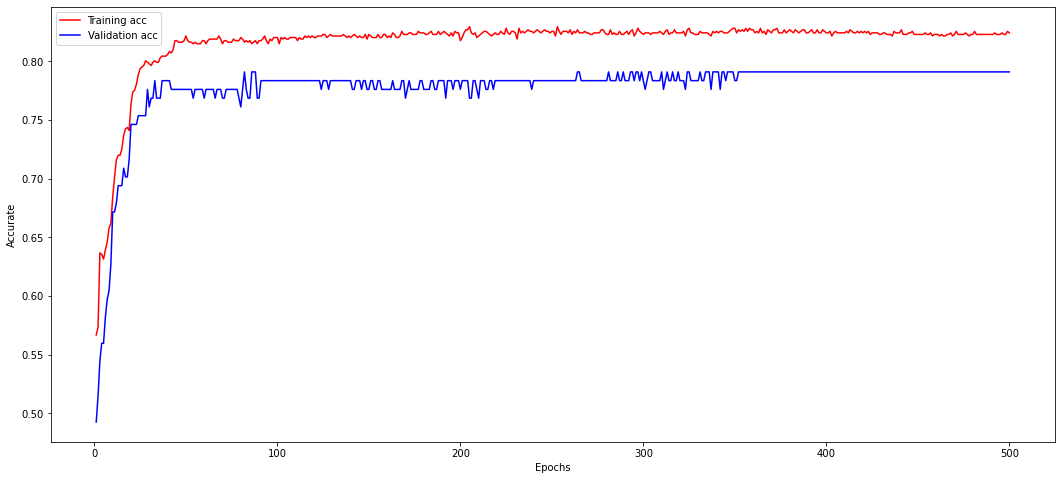

In [20]:
show_acc(history1)

In [21]:
pred1 = nn_model1.predict_classes(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred1.reshape((418,))})
output.to_csv('nn1.csv', index = False)

## Final model

In [22]:
nn_modelf = Sequential()

nn_modelf.add(Dense(8, input_shape = (x_train.shape[1],), activation = 'relu'))
nn_modelf.add(Dense(16, activation = 'relu'))
nn_modelf.add(Dense(1, activation = 'sigmoid'))

nn_modelf.compile(loss = ['binary_crossentropy'], metrics=['binary_accuracy'], optimizer = 'adam')

# nn_model.compile(optimizer =optimizers.RMSprop(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

historyf = nn_modelf.fit(X_train, y, epochs = 666, batch_size = 128)

Epoch 1/666
7/7 [==============================] - 0s 1ms/step - loss: 0.7526 - binary_accuracy: 0.3412
Epoch 2/666
7/7 [==============================] - 0s 1ms/step - loss: 0.7215 - binary_accuracy: 0.4299
Epoch 3/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6963 - binary_accuracy: 0.5275
Epoch 4/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6747 - binary_accuracy: 0.5668
Epoch 5/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6574 - binary_accuracy: 0.6285
Epoch 6/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6428 - binary_accuracy: 0.6790
Epoch 7/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6297 - binary_accuracy: 0.6925
Epoch 8/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6183 - binary_accuracy: 0.7026
Epoch 9/666
7/7 [==============================] - 0s 1ms/step - loss: 0.6064 - binary_accuracy: 0.7082
Epoch 10/666
7/7 [==============================] - 0s 1ms/step 

In [23]:
predf = nn_modelf.predict_classes(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predf.reshape((418,))})
output.to_csv('nn2.csv', index = False)

### References

[Missing Data in NN](https://stackoverflow.com/questions/52570199/multivariate-lstm-with-missing-values)

[How to use Data Scaling Improve Deep Learning Model Stability and Performance](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)